# Coronavirus disease 2019 (COVID-19) visualization and time series forecasting 

Data is sourced from repository maintained by John Hopkins University Center for Systems Science and Engineering (CSSE) who have collated data from around the world. 

Their dataset includes time series data tracking the number of people affected by COVUD-19 worldwide, including:

* confirmed tested cases of Coronavirus infection
* the number of people who have reportedly died while sick with Coronavirus
* the number of people who have reportedly recovered from it

For several countries (i.e., Australia, Canada, China, Denmark, France, the Netherlands and the United Kingdom) there are separate rows for Provinces or States. In our Data Visualization and time series forecasting we aggregated data across Provinces/States. 

The following link contains the raw data.

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [1313]:
# ========== Part 1: importing the relevant libraries and data sets
import pandas as pd
import numpy as np
import math

# URL to the raw dataset provided by John Hopkins University
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

confirmed_url = "time_series_covid19_confirmed_global.csv"
dead_url = "time_series_covid19_deaths_global.csv"
recovered_url = "time_series_covid19_recovered_global.csv"

df = pd.read_csv(base_url + confirmed_url)
confirmed_copy = df.copy()  # for time series file with provinces
df = df.drop(["Lat", "Long"], axis=1)

# The Following function combines all the numbers from the separate Provinces belonging
# to the same country

def combine_provinces(x):
    df = pd.read_csv(base_url + x)
    df = df.drop(["Lat", "Long"], axis=1)
    to_concat = df[df["Province/State"].notna()]["Country/Region"].unique()
    # We have to combine the numbers from the countries that are split up into provinces
    for country in to_concat:
        new_row = df[df["Country/Region"] == country].sum()
        new_row["Country/Region"] = country
        new_row["Province/State"] = np.NaN
        df = df.drop(df[df["Country/Region"] == country].index)
        df = df.append(new_row, ignore_index=True)

    df = df[df["Province/State"].isna()].drop("Province/State", axis=1)  # take only countries (no territories)
    return df


In [1302]:
# ========== Part 2: Input to this function is the Country for which you want to generate graphs: 
# For Example, Netherlands, France, Germany

def create_np_array_country(x):
    country_index = confirmed[confirmed["Country/Region"] == x].index
    country = x
    confirmed_cases = np.zeros(confirmed.shape[1]-1)
    recovered_cases = np.zeros(recovered.shape[1]-1)
    dead_cases = np.zeros(dead.shape[1]-1)

    for i in range(1,len(confirmed_cases)):
        confirmed_cases[i] = int(confirmed.iloc[country_index,i])
        recovered_cases[i] = int(recovered.iloc[country_index,i])
        dead_cases[i] = int(dead.iloc[country_index,i])

    # iterating the columns
    date = []
    
    for col in confirmed.columns:
        date.append(col)
        
    # getting all the columns headers except the first one
    array_dates = np.array(date[1:])
    # storing numbers as integers
    confirmed_cases = confirmed_cases.astype(int)   
    recovered_cases = recovered_cases.astype(int)
    dead_cases = dead_cases.astype(int)
    
    return country,array_dates,confirmed_cases,recovered_cases,dead_cases

# Function to make sure we plot the numbers according to the numbers of a specific country

def get_y_axes():
    # getting the nearest 100,000 (rounded up) confirmed_nr and nearest 1000 (rounded up) dead_nr
    nearest_confirmed = math.ceil(np.max(confirmed_nr)/100000)
    nearest_dead = math.ceil(np.max(dead_nr)/1000)
    max_confirmed = nearest_confirmed*100000
    max_dead = nearest_dead*1000
    
    return max_confirmed,max_dead

def get_y_axes_daily():
    # getting the nearest 100,000 (rounded up) confirmed_nr and nearest 1000 (rounded up) dead_nr
    nearest_daily_confirmed = math.ceil(np.max(daily_confirmed)/1000)
    nearest_daily_dead = math.ceil(np.max(daily_dead)/100)
    max_daily_confirmed = nearest_daily_confirmed*1000
    max_daily_dead = nearest_daily_dead*100
    
    return max_daily_confirmed,max_daily_dead


In [1303]:
# ========== Part 3: calculating the daily confirmed cases and deaths based on the cumulative numbers and
# calculating a 7 day moving average

def get_daily_numbers(confirmed_cases,recovered_cases,dead_cases):
    daily_confirmed = np.zeros(len(confirmed_cases))
    daily_recovered = np.zeros(len(recovered_cases))
    daily_dead = np.zeros(len(dead_cases))
    
    for i in range(len(confirmed_cases)):
        if i > 1:
            previous_day_confirmed = confirmed_cases[i-1]
            previous_day_recovered = recovered_cases[i-1]
            previous_day_dead = dead_cases[i-1]            
            today_confirmed = confirmed_cases[i]
            today_recovered = recovered_cases[i]
            today_dead = dead_cases[i]            
            daily_confirmed[i] = today_confirmed - previous_day_confirmed
            daily_recovered[i] = today_recovered - previous_day_recovered
            daily_dead[i] = today_dead - previous_day_dead
            # In case the registered cumulative total is smaller than the day before
            if daily_dead[i] < 0:
                daily_dead[i] = 0
            if daily_confirmed[i] < 0:
                daily_confirmed[i] = 0
        daily_confirmed = daily_confirmed.astype(int)
        daily_recovered = daily_recovered.astype(int)
        daily_dead = daily_dead.astype(int)
        
    return daily_confirmed,daily_recovered,daily_dead

# Calculating a 7-day moving average

def Seven_day_moving_average():
    seven_day_average_confirmed = np.zeros(len(daily_confirmed))
    seven_day_average_dead = np.zeros(len(daily_dead))    
    seven_days_confirmed = []
    seven_days_dead = []
    
    for i in range(len(daily_confirmed)):
        if i > 5:
            for j in range(0,7):
                seven_days_confirmed.append(daily_confirmed[i-j])
                seven_days_dead.append(daily_dead[i-j])
                
            seven_day_average_confirmed[i] = sum(seven_days_confirmed)/len(seven_days_confirmed)
            seven_day_average_dead[i] = sum(seven_days_dead)/len(seven_days_dead)
            seven_days_confirmed = []
            seven_days_dead = []
                   
    return seven_day_average_confirmed.astype(int), seven_day_average_dead.astype(int)

In [1304]:
# ========== Part 4: Plotting the data for a specific country of interest

import matplotlib.pyplot as plt
import matplotlib as mpl

# Printing the Number of new cases and deaths for the last seven days
def Print_last_seven_days():
    print('Number of new cases and deaths for the last seven days in ' + str(country) + '\n')
    print(str(dates[-1]) + ': ' + str(daily_confirmed[-1]) + ' new cases and ' + str(daily_dead[-1]) + ' new deaths')
    print(str(dates[-2]) + ': ' + str(daily_confirmed[-2]) + ' new cases and ' + str(daily_dead[-2]) + ' new deaths')
    print(str(dates[-3]) + ': ' + str(daily_confirmed[-3]) + ' new cases and ' + str(daily_dead[-3]) + ' new deaths')
    print(str(dates[-4]) + ': ' + str(daily_confirmed[-4]) + ' new cases and ' + str(daily_dead[-4]) + ' new deaths')    
    print(str(dates[-5]) + ': ' + str(daily_confirmed[-5]) + ' new cases and ' + str(daily_dead[-5]) + ' new deaths')
    print(str(dates[-6]) + ': ' + str(daily_confirmed[-6]) + ' new cases and ' + str(daily_dead[-6]) + ' new deaths')    
    print(str(dates[-7]) + ': ' + str(daily_confirmed[-7]) + ' new cases and ' + str(daily_dead[-7]) + ' new deaths')
    
# Function to plot the cumulative confirmed cases and deaths as a function of time
def Plot_cumulative_numbers():
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].plot(dates,confirmed_nr,'-',color = 'deepskyblue',linewidth=4,label='Cases')
    axs[0].set_title('Total Cases ' + str(country),loc='center', pad= 20,fontsize='large')
    axs[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    axs[1].plot(dates,dead_nr,'-', color= [1.0, 0.5, 0.25],linewidth=4,label='Deaths')
    axs[1].set_title('Total Deaths ' + str(country),loc='center', pad= 20,fontsize='large')
    axs[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    ticks = [10,39,70,100,131,161,192,223,253,282] # a tick at the beginning of each month
    
    # Use the pyplot interface to change just one subplot...
    plt.sca(axs[0])
    plt.xticks(ticks,rotation=60)
    plt.yticks(np.arange(0, max_confirmed+1, step=max_confirmed/4))
    plt.grid(b=None, which='major', axis='y')
    plt.legend(loc = 'best', bbox_to_anchor = (0.75,-0.2,0,0), fontsize = 'x-large')
    plt.sca(axs[1])
    plt.xticks(ticks,rotation=60)
    plt.yticks(np.arange(0, max_dead+1, step=max_dead/4))
    plt.grid(b=None, which='major', axis='y')
    plt.legend(loc = 'best', bbox_to_anchor = (0.75,-0.2,0,0), fontsize = 'x-large')
    plt.show;
    
def Plot_daily_numbers():
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].bar(dates,daily_confirmed,color = 'deepskyblue',label='Cases')
    axs[0].plot(dates,seven_day_avg_confirmed,'-',color = 'black',linewidth=2,label='7-day moving average')   
    axs[0].set_title('Daily Cases ' + str(country),loc='center', pad= 20,fontsize='large')
    axs[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    axs[1].bar(dates,daily_dead,color= [1.0, 0.5, 0.25],label='Deaths')
    axs[1].plot(dates,seven_day_avg_dead,'-',color = 'black',linewidth=2,label='7-day moving average')    
    axs[1].set_title('Daily Deaths ' + str(country),loc='center', pad= 20,fontsize='large')
    axs[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    ticks = [10,39,70,100,131,161,192,223,253,282] # a tick at the beginning of each month
    
    # Use the pyplot interface to change just one subplot...
    plt.sca(axs[0])
    plt.xticks(ticks,rotation=60)
    plt.yticks(np.arange(0, max_daily_confirmed+1, step=max_daily_confirmed/4))
    plt.grid(b=None, which='major', axis='y')
    plt.legend(loc = 'best', bbox_to_anchor = (0.95,-0.2,0,0), fontsize = 'x-large')
    plt.sca(axs[1])
    plt.xticks(ticks,rotation=60)
    plt.yticks(np.arange(0, max_daily_dead+1, step=max_daily_dead/4))
    plt.grid(b=None, which='major', axis='y')
    plt.legend(loc = 'best', bbox_to_anchor = (0.95,-0.2,0,0), fontsize = 'x-large')
    plt.show;
    

Number of new cases and deaths for the last seven days in Netherlands

11/3/20: 8312 new cases and 29 new deaths
11/2/20: 8711 new cases and 39 new deaths
11/1/20: 9839 new cases and 51 new deaths
10/31/20: 11172 new cases and 87 new deaths
10/30/20: 10321 new cases and 56 new deaths
10/29/20: 8156 new cases and 61 new deaths
10/28/20: 10321 new cases and 70 new deaths

Plotting the cumulative cases/deaths and cases/deaths per day 



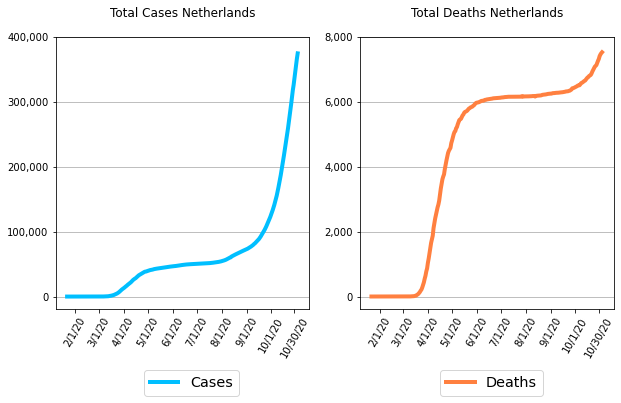

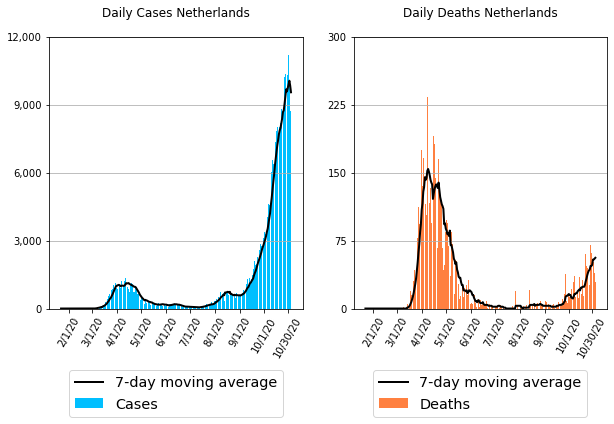

In [1305]:
# ========== Part 5: Running all the functions, for plotting the data

confirmed = combine_provinces(confirmed_url)
dead = combine_provinces(dead_url)
recovered = combine_provinces(recovered_url)

# Getting the data from a specific country and calculating cumulative numbers (cases/deaths)
country, dates,confirmed_nr,recovered_nr,dead_nr = create_np_array_country('Netherlands')
# adjusting the y-axes based on the numbers confirmed and dead
max_confirmed,max_dead = get_y_axes()

# Calculating daily numbers (cases/deaths)
daily_confirmed,daily_recovered,daily_dead = get_daily_numbers(confirmed_nr,recovered_nr,dead_nr)
# Calculating 7-day moving average (cases/deaths)
seven_day_avg_confirmed, seven_day_avg_dead = Seven_day_moving_average()
# adjusting the y-axes based on the daily numbers confirmed and dead
max_daily_confirmed,max_daily_dead = get_y_axes_daily()

#Plotting the cumulative and daily numbers
Plot_cumulative_numbers()
Plot_daily_numbers()

Print_last_seven_days()
print('\nPlotting the cumulative cases/deaths and cases/deaths per day \n')

# LSTM RNN for coronavirus time series forecasting


A recurrent neural network is a network that maintains some kind of state. For example, its output could be used as part of the next input, so that information can propogate along as the network passes over the sequence. In the case of an LSTM, for each element in the sequence, there is a corresponding hidden state ht, which in principle can contain information from arbitrary points earlier in the sequence. We can use the hidden state to predict words in a language model, part-of-speech tags, or for example to forecasting time series.

Our analysis was inspired and follows the logic provided by Usman Malik in the following blog post

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

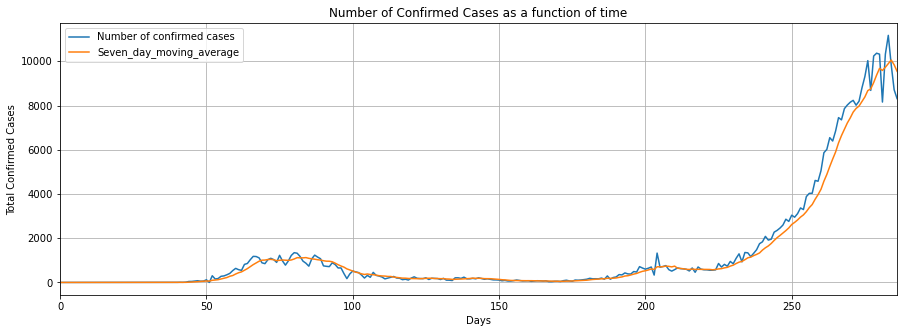

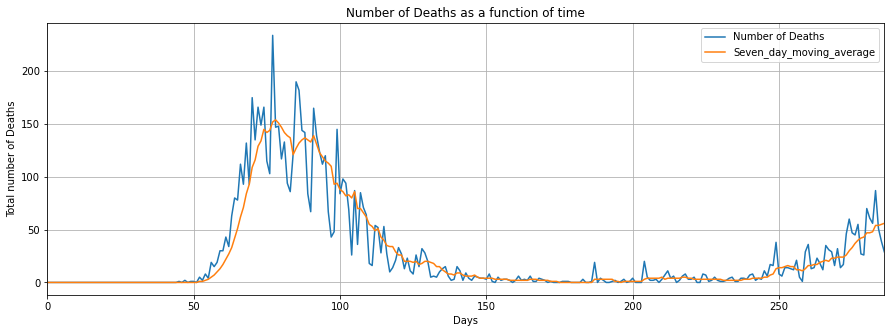

In [1306]:
# ========== Part 6: Here we prepare the data to be trained by our forecasting model and plot the
# number of confirmed cases and deaths per day from the start of the pandemic until now.

confirmed_data = daily_confirmed.astype(float)
dead_data = daily_dead.astype(float)

def Plot_Confirmed_per_day():
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('Number of Confirmed Cases as a function of time')
    plt.ylabel('Total Confirmed Cases')
    plt.xlabel('Days')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(confirmed_data,label = 'Number of confirmed cases')
    plt.plot(seven_day_avg_confirmed, label = 'Seven_day_moving_average')
    plt.legend()
    plt.show()

def Plot_Death_per_day():
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('Number of Deaths as a function of time')
    plt.ylabel('Total number of Deaths')
    plt.xlabel('Days')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(dead_data,label= 'Number of Deaths')
    plt.plot(seven_day_avg_dead, label = 'Seven_day_moving_average')
    plt.legend()
    plt.show()
    
# Plotting the number of confirmed cases and deaths over time
Plot_Confirmed_per_day()
Plot_Death_per_day()

In [1307]:
# =========== Part 7: Splitting data in train/test sets; Data Normalization; creating sequences
test_data_size = 21
confirmed_train_data = confirmed_data[:-test_data_size]
confirmed_test_data = confirmed_data[-test_data_size:]

# Feature Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
confirmed_train_data_normalized = scaler.fit_transform(confirmed_train_data.reshape(-1, 1))
confirmed_test_data_normalized = scaler.fit_transform(confirmed_test_data.reshape(-1, 1))

# Converting data to Tensors
confirmed_train_data_normalized = torch.FloatTensor(confirmed_train_data_normalized).view(-1)
confirmed_test_data_normalized = torch.FloatTensor(confirmed_test_data_normalized).view(-1)

# Training window size
train_window = 14

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(confirmed_train_data_normalized, train_window)

# the size of confirmed_train_data_normalized == the full dataset - test_data_size (i.e., 21)
# the size of train_inout_seq == confirmed_train_data_normalized - train_window (i.e., 14)

print('The size of the training data set is ' + str(confirmed_train_data_normalized.shape[0]))
print('The size of the train_inout_seq is ' + str(len(train_inout_seq)))

The size of the training data set is 266
The size of the train_inout_seq is 252


In [1308]:
# =========== Part 8: Specifying the LSTM Model, with 1 hidden_layer with size = 
# loss function = Mean Square Error (MSE) Loss, learning rate = 10e-4, optimizer = Adam

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4)
print(model)   

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


epoch: 0 loss: 0.05818065995449384
epoch: 1 loss: 0.053376283228453045
epoch: 2 loss: 0.026322952801017294
epoch: 3 loss: 0.03412811626579102
epoch: 4 loss: 0.017942029154003957
epoch: 5 loss: 0.03234318124147002
epoch: 6 loss: 0.01904746966876063
epoch: 7 loss: 0.022830830086112558
epoch: 8 loss: 0.0067678319241922325
epoch: 9 loss: 0.007986854432942328
epoch: 10 loss: 0.00365137419100155
epoch: 11 loss: 0.0042121230900380655
epoch: 12 loss: 0.00309802096399787
epoch: 13 loss: 0.003655405183114759
epoch: 14 loss: 0.00326454557150623
epoch: 15 loss: 0.004048262125020901
epoch: 16 loss: 0.0037550130751555283
epoch: 17 loss: 0.004281848418867052
epoch: 18 loss: 0.004081980580894491
epoch: 19 loss: 0.004733131436787228


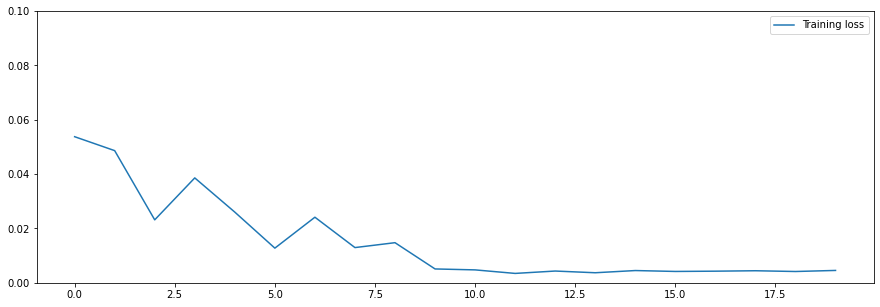

In [1309]:
# =========== Part 9: Training the Model, plot training loss
def Train_model():
    epochs = 20
    train_hist = np.zeros(epochs)

    for i in range(epochs):
        all_losses = []
    
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
            # it predicts the y value for each train_inout_seq, it's loss and
            # the backpropagates the error
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            loss = single_loss.item()
            all_losses.append(loss)
            single_loss.backward()
            optimizer.step()
        # averaging the loss over all seqs in train_inout_seq and storing in
        # train_hist in order to plot later
        avg_loss = (sum(all_losses)/len(all_losses))
        print('epoch: ' +str(i) + ' loss: ' + str(avg_loss))
        train_hist[i] = avg_loss
    return model.eval(), train_hist

Train_model()
plt.plot(train_hist, label="Training loss")
plt.ylim((0, 0.1))
plt.legend();

In [1310]:
# ========== Part 10: making predictions on the test data set and creating an x-variable
# that holds the days for which we make our predictions
fut_pred = 14
test_inputs = confirmed_test_data_normalized[-train_window:].tolist()
x = []
for i in range(len(confirmed_data)-fut_pred-1,len(confirmed_data)):
    x.append(i)

# Putting the Model in evaluation mode, in order to make predictions on our test data
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

# inverse transform the scaled predictions        
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
# inserting the last value of the confirmed_data for a smooth transition in the graph
actual_predictions = np.insert(actual_predictions,0,confirmed_data[-fut_pred-1])
actual_cases = confirmed_data[-fut_pred-1:]

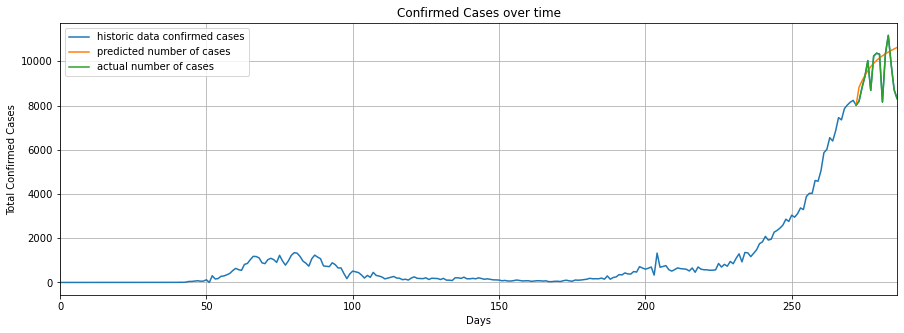

In [1311]:
def Plot_Confirmed_per_day():
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size

    plt.title('Confirmed Cases over time')
    plt.ylabel('Total Confirmed Cases')
    plt.xlabel('Days')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(confirmed_data,label='historic data confirmed cases')
    plt.plot(x,actual_predictions,label='predicted number of cases')
    plt.plot(x,actual_cases,label='actual number of cases')
    plt.legend()
    plt.show()
    
Plot_Confirmed_per_day()

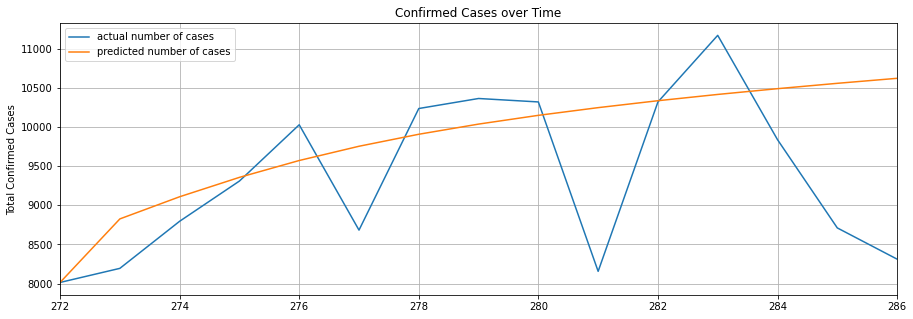

In [1312]:
def Plot_Predictions_last_x_days():
    plt.title('Confirmed Cases over Time')
    plt.ylabel('Total Confirmed Cases')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)

    plt.plot(x,confirmed_data[-len(actual_predictions):],label='actual number of cases')
    plt.plot(x,actual_predictions,label='predicted number of cases')
    plt.legend()
    plt.show()
    
Plot_Predictions_last_x_days()

# Conclusion

As you can see from the forecasted time series of our LSTM RNN, it does a pretty good job in predicted the general trend in the number of confirmed cases for the upcoming 14 days. Accuracy is very high for the first couple of forecasted days and then drops slightly over time.